In [21]:
%run 00_config_and_utils.ipynb

adj = pd.read_parquet("../data/processed/adj_close.parquet") # loads the saved data from notebook 1
ret = pd.read_parquet("../data/processed/ret.parquet")
spy_ret = pd.read_parquet("../data/processed/spy_ret.parquet")["SPY"]

adj.shape, ret.shape, spy_ret.shape

((2513, 50), (2512, 50), (2512,))

In [22]:
L = CONFIG["lookback_signal_mom"]
skip = CONFIG["skip_mom"]

# momentum  looks back 12 month but skip most recent month
mom = adj.shift(skip) / adj.shift(L) - 1.0

# inverse the last 5 trading days
rev = -(ret.rolling(CONFIG["lookback_signal_rev"]).sum())

# computes the last 20 days volatility per stock and negate it so lower-vol stocks get higher signal values
lowvol = -(ret.rolling(CONFIG["lookback_signal_vol"]).std())

mom.tail(2), rev.tail(2), lowvol.tail(2)

(Ticker          AAPL      ABBV       ACN      ADBE       AMD      AMZN  \
 Date                                                                     
 2025-12-29  0.079804  0.309002 -0.304846 -0.291155  0.696413  0.000480   
 2025-12-30  0.081427  0.315077 -0.296481 -0.288853  0.739405  0.027175   
 
 Ticker          AVGO       BAC     BRK-B     CMCSA  ...       TMO      TSLA  \
 Date                                                ...                       
 2025-12-29  0.670546  0.215345  0.114617 -0.281932  ...  0.124618 -0.077226   
 2025-12-30  0.653997  0.225787  0.119217 -0.275860  ...  0.123855 -0.052760   
 
 Ticker           TXN       UNH       UNP       UPS         V       WFC  \
 Date                                                                     
 2025-12-29 -0.112875 -0.336942  0.021939 -0.190197  0.048373  0.221110   
 2025-12-30 -0.093865 -0.343374  0.024981 -0.189823  0.049563  0.222346   
 
 Ticker           WMT       XOM  
 Date                            
 2025-

In [23]:
# loops over the dates. for each date, takes the cross-section of signal values on that date. if less than 5 values, skip.
# winsorize to cap top and bottom 1 percentile and standardise each signal with mean 0 and std 1

def clean_signal(sig_df: pd.DataFrame):
    out = sig_df.copy()
    for dt in out.index:
        row = out.loc[dt].dropna()
        if len(row) < 5:
            continue
        row = winsorize_series(row, p=0.01)
        out.loc[dt, row.index] = row
    out = zscore_cross_section(out)
    return out

mom_z = clean_signal(mom)
rev_z = clean_signal(rev)
lowvol_z = clean_signal(lowvol)

signals_z = pd.concat({"mom": mom_z, "rev": rev_z, "lowvol": lowvol_z}, axis=1)
signals_z.columns.names = ["signal", "ticker"]

signals_z.tail(2)

signal           mom                                                    \
ticker          AAPL      ABBV       ACN      ADBE       AMD      AMZN   
Date                                                                     
2025-12-29 -0.108565  0.781220 -1.601837 -1.548687  2.285216 -0.416511   
2025-12-30 -0.135530  0.752525 -1.571882 -1.542889  2.365313 -0.341732   

signal                                              ...    lowvol            \
ticker          AVGO       BAC     BRK-B     CMCSA  ...       TMO      TSLA   
Date                                                ...                       
2025-12-29  2.184796  0.417629  0.026585 -1.512882  ...  0.828065 -1.458735   
2025-12-30  2.040695  0.413152  0.008102 -1.493507  ...  0.827234 -1.537431   

signal                                                                  \
ticker           TXN       UNH       UNP       UPS         V       WFC   
Date                                                                     
2025-12-29 -0.210104 -0.267002  0.853711  0.173386 -0.044418  0.401044   
2025-12-30 -0.251775 -0.218005  0.799926  0.152354 -0.030450  0.380695   

signal                          
ticker           WMT       XOM  
Date                            
2025-12-29  0.549307  0.378962  
2025-12-30  0.524865  0.345723  

[2 rows x 150 columns]

In [24]:
# estimate rolling betas vs SPY
# It computes each stock's market beta over a rolling window, without runnning explicit regression every day
# since beta is the slope of a SPY(y-axis) and stock(x-axis) graph, it is covariance divide by variance
# Cov(r(stock)r(spy)) / Var(r(spy))

win = CONFIG["lookback_beta"]
spy_var = spy_ret.rolling(win).var()
beta = ret.rolling(win).cov(spy_ret).div(spy_var, axis=0)

beta.to_parquet("data/processed/beta.parquet")
beta.tail()

Ticker,AAPL,ABBV,ACN,ADBE,AMD,AMZN,AVGO,BAC,BRK-B,CMCSA,...,TMO,TSLA,TXN,UNH,UNP,UPS,V,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2025-12-23,1.256452,0.409715,0.757573,0.825693,2.047479,1.323308,1.815835,0.953365,0.471780,0.597373,...,0.852813,2.242309,1.315140,0.311419,0.665243,0.762261,0.749422,1.012161,0.554861,0.513043
2025-12-24,1.255319,0.404626,0.764140,0.821598,2.053824,1.325459,1.818923,0.951588,0.470939,0.593574,...,0.851301,2.259931,1.315486,0.306167,0.663473,0.757574,0.749601,1.009884,0.560965,0.513684
2025-12-26,1.255904,0.402890,0.767329,0.822149,2.049481,1.326365,1.812804,0.953374,0.471128,0.594849,...,0.851618,2.259058,1.314053,0.304196,0.663651,0.757998,0.750451,1.010453,0.564346,0.513621
2025-12-29,1.255789,0.401437,0.766513,0.823297,2.051441,1.324998,1.810163,0.954676,0.469185,0.592157,...,0.851125,2.248222,1.314673,0.305600,0.661645,0.759494,0.749606,1.010188,0.558157,0.513537
2025-12-30,1.255871,0.401614,0.766611,0.823370,2.051277,1.324664,1.810383,0.954756,0.468911,0.591857,...,0.851159,2.248349,1.314585,0.305204,0.661941,0.759447,0.749712,1.010296,0.558429,0.513343


In [25]:
# purification step to remove any part of the signal that is basically just high or low beta
# high alpha is bad as it favours riskier tech stocks
# shouldnt remove if the strat is trying to time the market as high beta can potentially lead to more gains

def neutralize_vs_beta(signal_df: pd.DataFrame, beta_df: pd.DataFrame):
    common_idx = signal_df.index.intersection(beta_df.index) # pick only dates that exist in both tables
    out = pd.DataFrame(index=common_idx, columns=signal_df.columns, dtype=float) # create a empty output table for those dates to be filled later

    for dt in common_idx:
        s = signal_df.loc[dt]
        b = beta_df.loc[dt]
        mask = s.notna() & b.notna()
        if mask.sum() < 10:  # skip days where too little tickers are avail
            continue

        x = b[mask].values # numpy array of beta
        y = s[mask].values # numpy array of signal values
        X = np.column_stack([np.ones_like(x), x]) # create a (n, 2) matrix: column 1 all 1s, column 2 is beta
        coef = np.linalg.lstsq(X, y, rcond=None)[0] # find the best coef[0] = a and coef[1] = c that minimises squared error. Uses least square method in LA
        resid = y - (X @ coef) # signal minus beta

        out.loc[dt, s[mask].index] = resid

    return zscore_cross_section(out)

from pathlib import Path
ROOT = Path.cwd()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

beta = pd.read_parquet(ROOT / "data/processed/beta.parquet")

mom_p = neutralize_vs_beta(mom_z, beta)
rev_p = neutralize_vs_beta(rev_z, beta)
lowvol_p = neutralize_vs_beta(lowvol_z, beta)

signals_p = pd.concat({"mom": mom_p, "rev": rev_p, "lowvol": lowvol_p}, axis=1)
signals_p.columns.names = ["signal", "ticker"]

signals_p.to_parquet("data/processed/signals_purified.parquet")
signals_p.tail(2)

signal           mom                                                    \
ticker          AAPL      ABBV       ACN      ADBE       AMD      AMZN   
Date                                                                     
2025-12-29 -0.313327  1.018843 -1.614051 -1.586895  1.766284 -0.664270   
2025-12-30 -0.355556  1.006985 -1.587408 -1.586898  1.818556 -0.604625   

signal                                              ...    lowvol            \
ticker          AVGO       BAC     BRK-B     CMCSA  ...       TMO      TSLA   
Date                                                ...                       
2025-12-29  1.780122  0.375237  0.208362 -1.437625  ...  1.026015  0.155324   
2025-12-30  1.607856  0.368526  0.201861 -1.415540  ...  1.032144  0.085813   

signal                                                                  \
ticker           TXN       UNH       UNP       UPS         V       WFC   
Date                                                                     
2025-12-29  0.395427 -1.065075  0.796195  0.099119 -0.180858  0.723077   
2025-12-30  0.355492 -1.022269  0.732460  0.072385 -0.166342  0.706210   

signal                          
ticker           WMT       XOM  
Date                            
2025-12-29  0.281297  0.011482  
2025-12-30  0.248298 -0.035629  

[2 rows x 150 columns]

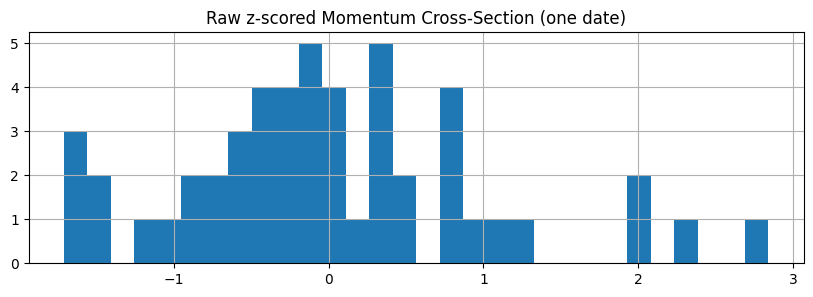

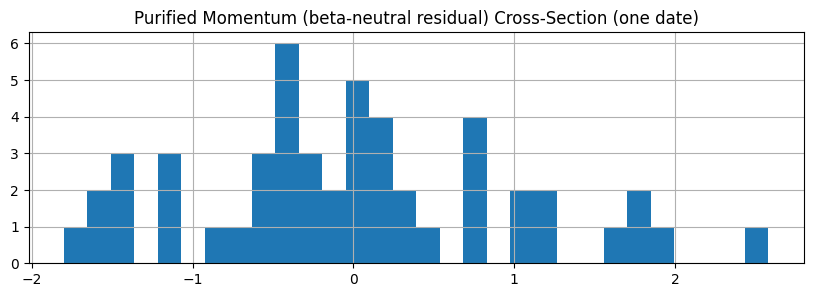

(count    50.000000
 mean     -0.011128
 std       0.262880
 min      -0.567221
 25%      -0.175479
 50%      -0.000920
 75%       0.168434
 max       0.664810
 dtype: float64,
 count    50.000000
 mean     -0.139515
 std       0.275213
 min      -0.707173
 25%      -0.348905
 50%      -0.145286
 75%       0.062556
 max       0.436866
 dtype: float64)

In [26]:
#plot histogram of raw momentum signal and purified momentum signal
import matplotlib.pyplot as plt

dt = signals_p.index.dropna()[-1]

plt.figure(figsize=(10,3))
signals_z.loc[dt, ("mom", slice(None))].droplevel(0).hist(bins=30)
plt.title("Raw z-scored Momentum Cross-Section (one date)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,3))
signals_p.loc[dt, ("mom", slice(None))].droplevel(0).hist(bins=30)
plt.title("Purified Momentum (beta-neutral residual) Cross-Section (one date)")
plt.grid(True)
plt.show()

idx_before = signals_z.index.intersection(beta.index)
idx_after  = signals_p.index.intersection(beta.index)

corr_before = signals_z.loc[idx_before, "mom"].corrwith(beta.loc[idx_before])
corr_after  = signals_p.loc[idx_after,  "mom"].corrwith(beta.loc[idx_after])


corr_before.describe(), corr_after.describe()

In [27]:
# check if my zscore is working
dt = signals_p.index[-1]  # pick a date

mom_raw = signals_z.loc[dt, ("mom", slice(None))].droplevel(0)
mom_pur = signals_p.loc[dt, ("mom", slice(None))].droplevel(0)

print("raw mom mean/std:", mom_raw.mean(), mom_raw.std())
print("pur mom mean/std:", mom_pur.mean(), mom_pur.std())

raw mom mean/std: -4.274358644806853e-17 1.0
pur mom mean/std: 2.6090241078691177e-17 1.0
